In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
anno_path = "../data/data/ydata-tvsum50-anno.tsv"

anno_data = open(anno_path).read()

In [4]:
anno_data = anno_data.split("\n")
anno_data = [row.split("\t") for row in anno_data]

In [5]:
header = anno_data[0]
anno_data = anno_data[1:]

In [6]:
data = []
for row in anno_data:
    if len(row) < 3:
        break
    video_id = row[0]
    genre = row[1]
    ratings = row[2]

    data.append({
            "id": video_id,
            "genre": genre,
            "rating": [int(rating) for rating in ratings.split(",")]   
        })

In [7]:
def filter_by_id(ratings, video_id):
    return [rating for rating in ratings if rating["id"] == video_id]

video_ids = list(set([rating["id"] for rating in data]))

In [8]:
def plot_rating(rating_data):
    x_axis = range(len(rating_data))
    plt.plot(x_axis, rating_data)
    plt.title("Rating over time")
    plt.xlabel("Time")
    plt.ylabel("Rating")

In [9]:
def get_samples(to_sample):
    ratings_to_sample = to_sample['rating']
    # Get a sample from every 2 seconds.
    sample = []
    for i, rating in enumerate(ratings_to_sample):
        if i % 60 == 0:
            sample.append(int(rating))
    return sample

In [10]:
single_video_ratings = filter_by_id(data, video_ids[37])
print len(single_video_ratings[0]['rating'])

3705


In [11]:
samples = []

for row in single_video_ratings:
    samples.append(get_samples(row))

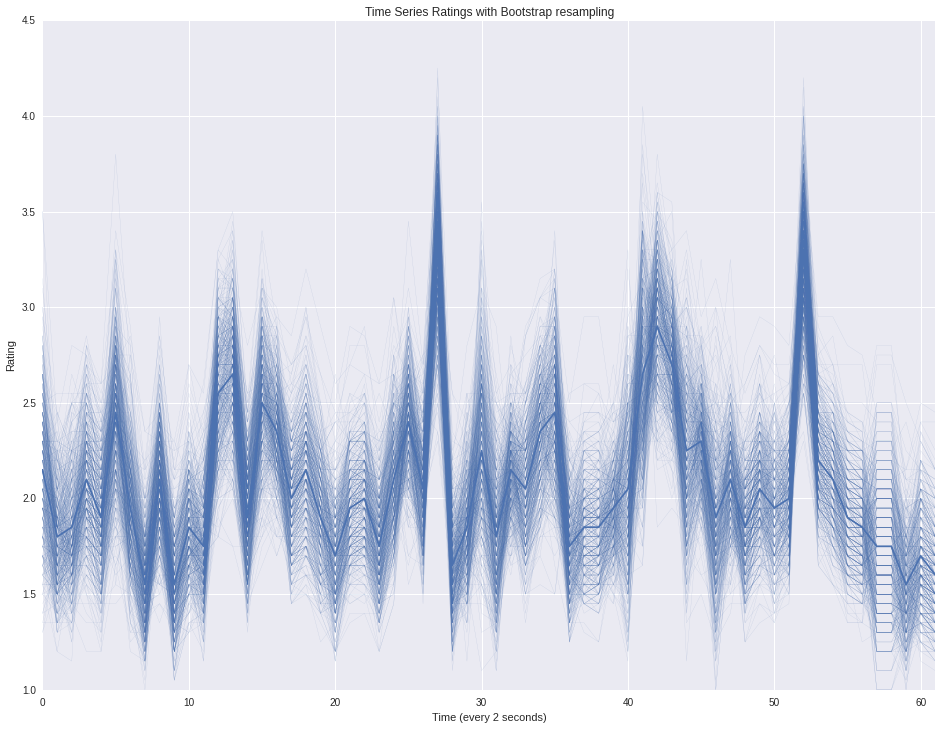

In [12]:
plt.figure(figsize=(16, 12))
sns.tsplot(samples, err_style="boot_traces", n_boot=500)
plt.title("Time Series Ratings with Bootstrap resampling")
plt.xlabel("Time (every 2 seconds)")
plt.ylabel("Rating")

### Gaussian Process Regression

In [13]:
import GPy
from IPython.display import display
plt.rcParams['figure.figsize'] = (16.0, 12.0)

In [14]:
x_axis = range(len(samples[0]))
sample_locs = [x * 60 for x in x_axis]

In [15]:
X = np.reshape(np.array(sample_locs * 20), (-1, 1))
Y = np.reshape(np.array([item for sublist in samples for item in sublist]), (-1, 1))

__RBF Kernel__

Here we attempt to use an RBF Kernel in our GP model.

lengthscale how many data points (on the x axis) we want our RBF to encorporate, 60 would be 2 seconds, and each annotation is every 2 seconds. Increasing this should "smooth" the kernel.


Name                              : GP regression
Log-likelihood                    : -2307.06683759
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    0.5  |     +ve      |         |         
  rbf.lengthscale          |   30.0  |     +ve      |         |         
  Gaussian_noise.variance  |    1.0  |     +ve      |         |         


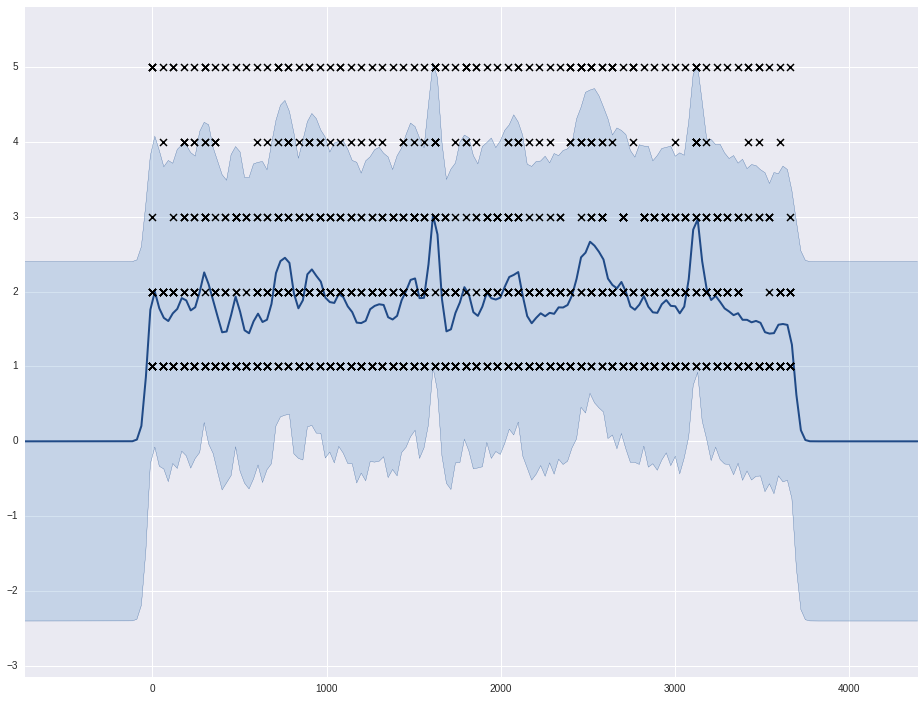

In [16]:
kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=30.0)
gp = GPy.models.GPRegression(X, Y, kernel)
print gp
fig = gp.plot()